In [ ]:
# default_exp classification.data.mixmethods

In [ ]:
# hide
import warnings

warnings.filterwarnings("ignore")

%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.export import *
from nbdev.imports import Config as NbdevConfig

nbdev_path = str(NbdevConfig().path("nbs_path") / "data")
nbdev_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

<IPython.core.display.Javascript object>

# MixUp and Friends
> Classes that can apply the MixUp (and variants) data augmentation to your training.

In [ ]:
# export
from typing import Union
import numpy as np
import torch
from torch import tensor
import torch.nn.functional as F
from torch.distributions import Beta
import abc

from fastcore.all import delegates, ifnone, store_attr

<IPython.core.display.Javascript object>

In [ ]:
# hide
from fastcore.all import *

<IPython.core.display.Javascript object>

In [ ]:
# export
class MixHandler(abc.ABC):
    "A handler class for implementing `MixUp` style scheduling"

    def __init__(self, alpha: Union[int, float] = 0.5, conf_prob: float = 1.0):
        store_attr("alpha, conf_prob")
        if self.alpha > 0.0:
            self.distrib = Beta(tensor(alpha), tensor(alpha))
        else:
            self.distrib = Beta(tensor(1.0), tensor(1.0))

        self._has_ended = False

        self.lam_a = 1
        self.lam_b = 1 - self.lam_a

        self.inputs = None
        self.targets = None
        self.mix_inputs = None
        self.mix_targets = None
        self.device = None

    def reset_lams(self):
        self.lam_a = 1
        self.lam_b = 1 - self.lam_a

    def stop(self):
        "stops the mixmethod from furthur activation"
        self._has_ended = True

    def __call__(self, inputs: torch.Tensor, targets: torch.Tensor, *args, **kwargs):
        self.device = ifnone(self.device, inputs.device)

        if self._has_ended:
            self.targets, self.mix_targets = targets, targets
            self.inputs, self.mix_inputs = inputs, inputs
            self.reset_lams()

        else:
            self.targets, self.inputs = targets, inputs
            self.mix_inputs, self.mix_targets = self.call(
                inputs=inputs, targets=targets, *args, **kwargs
            )
        return self.mix_inputs

    @abc.abstractmethod
    def call(self, inputs: torch.Tensor, targets: torch.Tensor, *args, **kwargs):
        "The main function call for MixUP (and variants) exist here !!!"
        raise NotImplementedError

    def compute_loss(self, outputs: torch.Tensor, criterion):
        "Calculates loss for the Mixmethod"
        loss_a = criterion(outputs, self.targets)
        loss_b = criterion(outputs, self.mix_targets)
        return torch.mean(loss_a * self.lam_a + loss_b * self.lam_b)

<IPython.core.display.Javascript object>

Most `Mix` variants will perform the data augmentation on the batch, so to implement your `Mix` you should adjust the `call` event with however your training regiment requires. Also if a different loss function is needed, you should adjust the `compute_loss` as well. 

First we'll look at a very minimalistic example to show how our data is being generated with the `DOGS` dataset:

In [ ]:
import albumentations as A
from functools import partial
from fastcore.all import Path
from albumentations.pytorch import ToTensorV2

from lightning_cv.core.utils.common import show_images
from lightning_cv.config import get_cfg, get_class_path
from lightning_cv.core.losses import LabelSmoothingCrossEntropy
from lightning_cv.core.utils.data import download_data, Urls, norm_range
from lightning_cv.classification.modelling.backbones import create_cnn_backbone
from lightning_cv.classification.modelling.classifiers import create_classifier_head
from lightning_cv.classification.data.datasets import (
    create_dataset,
    ClassificationDatasetCatalog,
    ImageFolderDataset,
)

<IPython.core.display.Javascript object>

In [ ]:
cfg = get_cfg()

download_data(Urls.DOGS)

data_path = Path(nbdev_path) / "cats_and_dogs_filtered"

data_path.ls()

cls_dict = dict(cats=0, dogs=1)

train_dset = partial(
    ImageFolderDataset, source=data_path / "train", classes=cls_dict, test=False
)
valid_dset = partial(
    ImageFolderDataset, source=data_path / "validation", classes=cls_dict, test=False
)

ClassificationDatasetCatalog.register("my_train_dset", train_dset)
ClassificationDatasetCatalog.register("my_valid_dset", valid_dset)

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/14 17:34:02 lcv.core.utils.data]: Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


<IPython.core.display.Javascript object>

In [ ]:
# Update Config
cfg.TRANSFORMS.TRAIN.NAME = "AugTransforms"
cfg.TRANSFORMS.TRAIN.LOADER = "cv2_loader"
cfg.TRANSFORMS.TRAIN.ARGUMENTS = dict(img_size=255, p_cutout=0)
cfg.TRANSFORMS.VALID.NAME = "ImagenetNoAugmentTransform"
cfg.TRANSFORMS.VALID.LOADER = "pil_loader"
cfg.TRANSFORMS.VALID.ARGUMENTS = dict(img_size=255, interpolation="bicubic")

cfg.DATASETS.TRAIN = "my_train_dset"
cfg.DATASETS.VALID = "my_valid_dset"

cfg.DATALOADER.TRAIN_BATCH_SIZE = 9
cfg.DATALOADER.VALID_BATCH_SIZE = 9
cfg.DATALOADER.NUM_WORKERS = 0

# Create Datasets
dsets = create_dataset(cfg)

# Create DataLoaders
train_dl = torch.utils.data.DataLoader(
    dsets.TRAIN,
    num_workers=cfg.DATALOADER.NUM_WORKERS,
    shuffle=cfg.DATALOADER.SHUFFLE_TRAIN,
    batch_size=cfg.DATALOADER.TRAIN_BATCH_SIZE,
    pin_memory=cfg.DATALOADER.PIN_MEMORY,
)
valid_dl = torch.utils.data.DataLoader(
    dsets.VALID,
    num_workers=cfg.DATALOADER.NUM_WORKERS,
    shuffle=cfg.DATALOADER.SHUFFLE_VALID,
    batch_size=cfg.DATALOADER.VALID_BATCH_SIZE,
    pin_memory=cfg.DATALOADER.PIN_MEMORY,
)

INFO [03/14 17:34:02 lcv.classification.data.datasets]: Found 2000 files belonging to 2 classes.
INFO [03/14 17:34:02 lcv.classification.data.datasets]: Found 1000 files belonging to 2 classes.


<IPython.core.display.Javascript object>

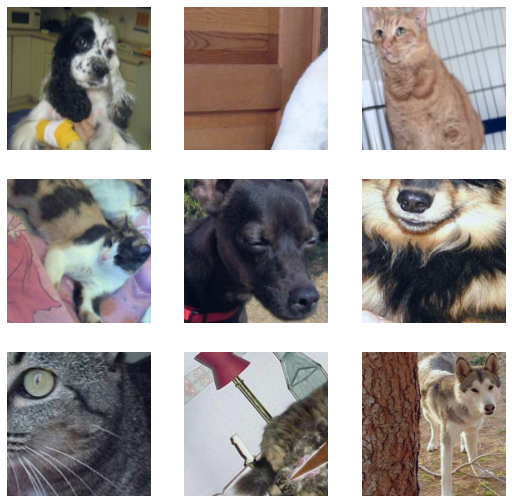

<IPython.core.display.Javascript object>

In [ ]:
images, targets = next(iter(train_dl))
orig_images = images.clone()
norm_range(images, value_range=None)
show_images(images, nrows=3, ncols=3)

In [ ]:
# export
class NoMix(MixHandler):
    "Default MixHandler that does not apply any mix to the inputs"

    def __init__(self):
        super(NoMix, self).__init__()

    def call(self, inputs, targets, *args, **kwargs):
        self.inputs, self.targets = inputs, targets
        return inputs, targets

<IPython.core.display.Javascript object>

This `Handler` does not perform `Mix` augmentation of the dataset.

We can examine the results of our `MixHandler` by grabbing our data like so:

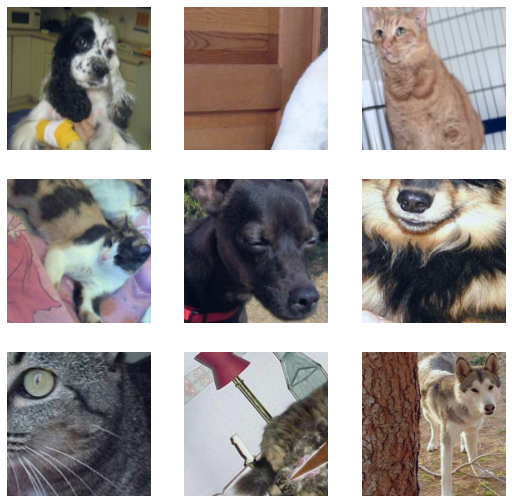

<IPython.core.display.Javascript object>

In [ ]:
mix = NoMix()
mix_images = mix(orig_images, targets)
norm_range(mix_images, value_range=None)
show_images(mix_images, nrows=3, ncols=3)

test_eq(mix.mix_inputs, mix.inputs)
test_eq(mix.mix_targets, mix.mix_targets)
test_eq(mix.lam_b, 1 - mix.lam_a)

In [ ]:
# hide
output = torch.randn(targets.shape[0], 2, requires_grad=True)
criterion = LabelSmoothingCrossEntropy()
orig_loss = criterion(output, targets)
mix_loss = mix.compute_loss(output, criterion)
with torch.no_grad():
    test_eq(orig_loss, mix_loss)

<IPython.core.display.Javascript object>

In [ ]:
# export
class Mixup(MixHandler):
    "Implementation of https://arxiv.org/abs/1710.09412"

    @delegates(MixHandler)
    def __ini__(self, **kwargs):
        super(Mixup, self).__init__(**kwargs)

    def call(self, inputs: torch.Tensor, targets: torch.Tensor, *args, **kwargs):
        "Applys Mixup to a batch of inputs given `conf_prob`"
        r = np.random.rand(1)
        bs, _, H, W = inputs.size()

        if r < self.conf_prob:
            rand_index = torch.randperm(bs, device=self.device)
            self.lam_a = self.distrib.sample((1,))
            self.lam_a = torch.tensor(self.lam_a, device=self.device)
            self.lam_b = 1 - self.lam_a
            mix_inputs = self.lam_a * inputs + (self.lam_b) * inputs[rand_index, :]
            targets, mix_targets = targets, targets[rand_index]
            return mix_inputs, mix_targets
        else:
            self.reset_lams()
            return inputs, targets

<IPython.core.display.Javascript object>

We can see that every so often an image gets "mixed" with another. 

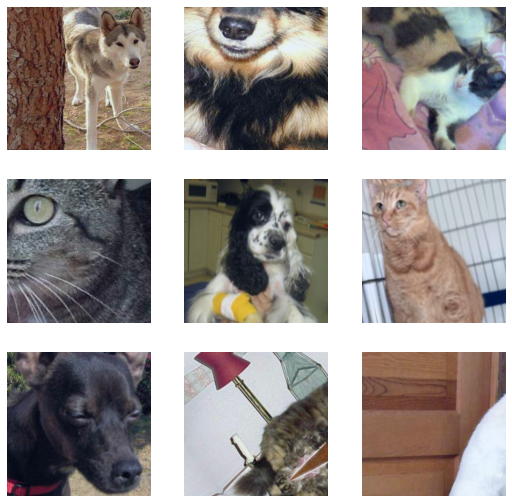

<IPython.core.display.Javascript object>

In [ ]:
mix = Mixup(alpha=0.4)
mix_images = mix(orig_images, targets)
norm_range(mix_images, value_range=None)
show_images(mix_images, nrows=3, ncols=3)

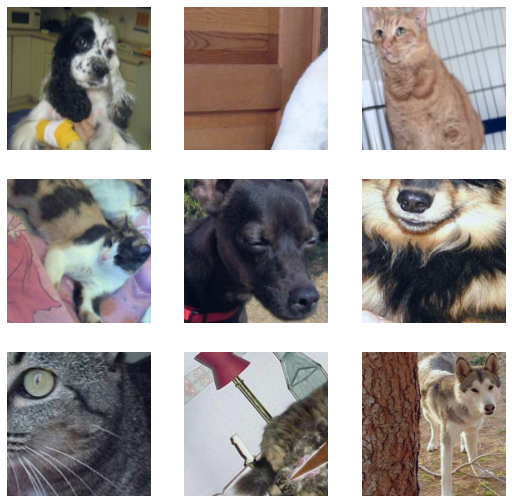

<IPython.core.display.Javascript object>

In [ ]:
mix.stop()
mix_images = mix(orig_images, targets)
norm_range(mix_images, value_range=None)
show_images(mix_images, nrows=3, ncols=3)

In [ ]:
# export
class Cutmix(MixHandler):
    "Implementation of `https://arxiv.org/abs/1905.04899`"

    @delegates(MixHandler)
    def __init__(self, alpha: Union[float, int] = 1.0, **kwargs):
        super(Cutmix, self).__init__(alpha=alpha, **kwargs)

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1.0 - lam)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.device)
        # uniform
        cx = torch.randint(0, W, (1,), device=self.device)
        cy = torch.randint(0, H, (1,), device=self.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

    def call(self, inputs: torch.Tensor, targets: torch.Tensor, *args, **kwargs):
        "Applys Mixup to a batch of inputs given `conf_prob`"
        r = np.random.rand(1)
        bs, _, H, W = inputs.size()

        if r < self.conf_prob:
            rand_index = torch.randperm(bs, device=self.device)
            self.lam_a = self.distrib.sample((1,))
            self.lam_a = torch.tensor(self.lam_a, device=self.device)
            self.lam_b = 1 - self.lam_a
            x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam_a)
            targets, mix_targets = targets, targets[rand_index]
            # avoid modifying in place
            mix_inputs = inputs.clone()
            mix_inputs[:, :, x1:x2, y1:y2] = inputs[rand_index, :, x1:x2, y1:y2]

            # adjust lambda to exactly match pixel ratio
            lam = (1 - ((x2 - x1) * (y2 - y1)) / float(W * H)).item()
            self.lam_a = self.lam_a * lam
            self.lam_b = 1 - self.lam_a

            return mix_inputs, mix_targets
        else:
            self.reset_lams()
            return inputs, targets

<IPython.core.display.Javascript object>

Similar to `MixUp`, `CutMix` will cut a random box out of two images and swap them together. We can look at a few examples below:

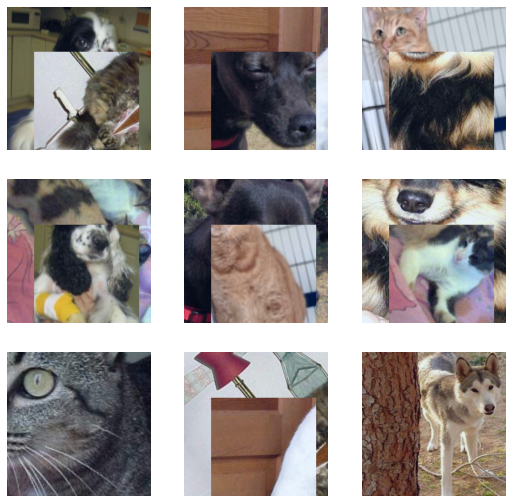

<IPython.core.display.Javascript object>

In [ ]:
mix = Cutmix(alpha=1.0)
mix_images = mix(orig_images, targets)
norm_range(mix_images, value_range=None)
show_images(mix_images, nrows=3, ncols=3)

# Export - 

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()

Converted 00_config.ipynb.
Converted 00a_core.utils.common.ipynb.
Converted 00b_core.utils.data.ipynb.
Converted 00c_core.optim.ipynb.
Converted 00d_core.schedules.ipynb.
Converted 00e_core.layers.ipynb.
Converted 00f_core.losses.py.ipynb.
Converted 01a_classification.data.transforms.ipynb.
Converted 01b_classification.data.datasets.ipynb.
Converted 01c_classification.modelling.backbones.ipynb.
Converted 01d_classification.modelling.classifiers.ipynb.
Converted 01e_classification.data.mixmethods.ipynb.
Converted 01f_classification.modelPL.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>